# **Notebook Google Colab: Deformable DETR**
This notebook is designed to run a Deformable DETR model on SSDD SAR dataset for ships detection.
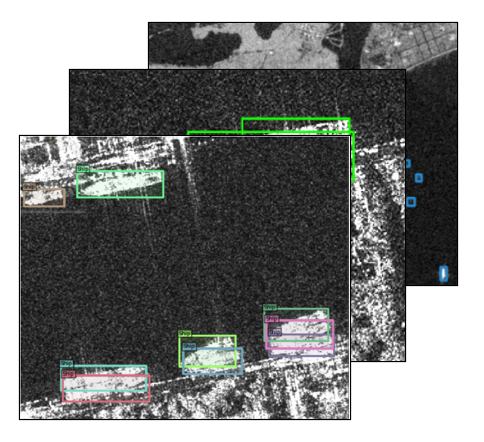

#Initializations and imports

In [ ]:
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8
!pip install --no-cache-dir coco-eval
!pip install -q pytorch-lightning
!pip install scikit-learn


from google.colab import drive


# Monter Google Drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5017 sha256=bdc7b0f2d2278ebf53f35924c45ed3b80c7ec3bf5b053dee36d96dff339450b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-66iudlep/wheels/a1/9f/46/f0e4e2fab494ddd7afba1839e7f6036f5ae804fc66a89093f0
Successfully built coco-eval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 54.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import os
import shutil
import json
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image
import numpy as np
from collections import defaultdict
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from transformers import AutoImageProcessor, DetrImageProcessor, DetrForObjectDetection, DeformableDetrForObjectDetection
from pytorch_lightning import Trainer
import torchvision

import pytorch_lightning as pl
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import clear_output

# Definition of classes and functions
Definition of classes and functions for loading data, creating COCO annotations and training the model.

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True,test=False,val=False):
        if train:
          ann_file = os.path.join(img_folder, "custom_train.json")
        elif val:
          ann_file = os.path.join(img_folder, "custom_val.json")
        elif test:
          ann_file = os.path.join(img_folder, "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


class DeformableDetr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)

         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896

         for name, param in self.model.named_parameters():
          param.requires_grad=True



         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader
     def save_pretrained(self, save_directory):
        self.model.save_pretrained(save_directory)

Defining methods and functions

In [ ]:
def create_coco_json(images_list, annotations_df, output_path):
    coco_json = {
        "info": {"description": "Pleiades Dataset"},
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": "Ship", "id": 0, "name": "Ship"}]
    }
    annotation_id = 0

    for image_id, image_name in enumerate(images_list):
        coco_json["images"].append({"file_name": image_name, "id": image_id})
        image_annotations = annotations_df[annotations_df['id'] == image_name]
        for _, row in image_annotations.iterrows():
            x, y, w, h = eval(row['bbox'])
            coco_json["annotations"].append({
                "iscrowd": 0,
                "image_id": image_id,
                "bbox": [x, y, w, h],
                "area": w * h,
                "category_id": 0,
                "id": annotation_id
            })
            annotation_id += 1

    with open(output_path, 'w') as f:
        json.dump(coco_json, f)
    print(f"Annotations saved in: {output_path}")


def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def convert_to_xyxy(box):
    xmin, ymin, width, height = box
    xmax = xmin + width
    ymax = ymin + height
    return [xmin, ymin, xmax, ymax]

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results


def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2

    return intersection_area / float(box1_area + box2_area - intersection_area)


def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    return precision, recall, f1_score


def calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold=0.5):

    if not pred_boxes or not true_boxes:
        return 0.0  # Si aucune prédiction ou vérité terrain, AP est 0


    sorted_indices = np.argsort(pred_scores)[::-1]
    pred_boxes = [pred_boxes[i] for i in sorted_indices]
    pred_scores = [pred_scores[i] for i in sorted_indices]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched_true_boxes = set()

    for i, pred_box in enumerate(pred_boxes):
        iou_scores = [iou(pred_box, convert_to_xyxy(true_box)) for true_box in true_boxes]

        if max(iou_scores) > iou_threshold:
            max_index = iou_scores.index(max(iou_scores))
            if max_index not in matched_true_boxes:
                tp[i] = 1
                matched_true_boxes.add(max_index)
            else:
                fp[i] = 1
        else:
            fp[i] = 1

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recalls = tp_cumsum / (len(true_boxes) + 1e-6)


    precisions = np.concatenate([[0.0], precisions, [0.0]])
    recalls = np.concatenate([[0.0], recalls, [1.0]])
    precisions = np.maximum.accumulate(precisions[::-1])[::-1]


    ap = np.trapz(precisions, recalls)

    return ap

def calculate_map_average(pred_boxes, pred_scores, true_boxes, iou_thresholds=np.arange(0.5, 1.0, 0.05)):

    aps = []
    for iou_threshold in iou_thresholds:
        ap = calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold)
        aps.append(ap)
    return np.mean(aps)

def plot_results(pil_img, scores, labels, pred_boxes, true_boxes):

    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()

    for score, (xmin, ymin, xmax, ymax) in zip(scores, pred_boxes):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color='red', linewidth=2))

        text = f'{score:.2f}'
        ax.text(xmin, ymin, text, fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))

    for (xmin, ymin, xmax, ymax) in true_boxes:
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color='green', linewidth=2))

    plt.axis('off')
    plt.show()

Defining K-Fold cross validation and annotations variables

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Configure paths
DATASET_PATH = '/content/drive/MyDrive/SSDD------Dataset'
ANNOTATIONS_PATH = '/content/drive/MyDrive/annotations_coco_ships.csv'
OUTPUT_DIR = '/content/output/'

image_files = sorted([f for f in os.listdir(DATASET_PATH) if f.endswith('.jpg')])
# Load annotations
annotations_df = pd.read_csv(ANNOTATIONS_PATH)

Defining datasets json configurations and folders


In [ ]:
os.makedirs("/content/Dataset_SSDD_SAR", exist_ok=True)
train_dir = "/content/Dataset_SSDD_SAR/train"
val_dir = "/content/Dataset_SSDD_SAR/val"
test_dir = "/content/Dataset_SSDD_SAR/test"
os.makedirs("/content/Dataset_SSDD_SAR/train", exist_ok=True)
os.makedirs("/content/Dataset_SSDD_SAR/val", exist_ok=True)
os.makedirs("/content/Dataset_SSDD_SAR/test", exist_ok=True)

#Training, validation and test processes

Dividing the available images into three sets: **training**, **validation** and **test**.
Using  K-fold cross-validation to ensure that each image is used for both
training and validation at least once. Here are the main steps:

1. **K-fold cross-validation**:  
   The dataset is divided into 10 folds. For each iteration, one fold is reserved for validation, while the others are used for training and testing.

2. **Division into subsets**:  
   Image indices are divided into three groups:  
   - **Training**: used to train the model.  
   - Validation**: used to adjust hyperparameters.  
   - Test**: used to evaluate final performance.

3. **COCO file creation** :  
   Image annotations are saved in COCO format files for each set (training, validation, test).

4. **Load datasets** :  
   - Images and annotations are loaded using the `CocoDetection` class.  
   - DataLoaders are created to manage training, validation and test sets.

5. **Display example** :  
   A training image is selected at random, and its annotations (bounding boxes) are displayed for viewing.

6. **Model training**:  
   The Deformable DETR model is trained on the images in the training set. Metrics are monitored, and execution times are measured.

7. **Save and evaluate**:  
   - The trained model is saved.  
   - An evaluation is performed on the test set to measure performance using metrics such as precision, recall, F1-score, mAP, etc.

In [ ]:
precision_list_tot = []
recall_list_tot = []
f1_list_tot = []
ap50_list_tot = []
ap75_list_tot = []
map_list_tot = []
for fold_idx, (train_idx, temp_idx) in enumerate(kf.split(image_files)):
  print("Start training for the fold number: "+str(fold_idx+1))
  train_images = [image_files[i] for i in train_idx]
  temp_images = [image_files[i] for i in temp_idx]
  val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
  for image_name in train_images:
          shutil.copy(os.path.join(DATASET_PATH, image_name), os.path.join("/content/Dataset_SSDD_SAR/train", image_name))
  for image_name in val_images:
          shutil.copy(os.path.join(DATASET_PATH, image_name), os.path.join("/content/Dataset_SSDD_SAR/val", image_name))
  for image_name in test_images:
          shutil.copy(os.path.join(DATASET_PATH, image_name), os.path.join("/content/Dataset_SSDD_SAR/test", image_name))
  create_coco_json(train_images, annotations_df, "/content/Dataset_SSDD_SAR/train/custom_train.json")
  create_coco_json(val_images, annotations_df, "/content/Dataset_SSDD_SAR/val/custom_val.json")
  create_coco_json(test_images, annotations_df, "/content/Dataset_SSDD_SAR/test/custom_test.json")
  processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
  train_dataset = CocoDetection(img_folder='/content/Dataset_SSDD_SAR/train', processor=processor, train=True, test=False, val=False)
  val_dataset = CocoDetection(img_folder='/content/Dataset_SSDD_SAR/val', processor=processor, train=False, test=False, val= True)
  test_dataset = CocoDetection(img_folder='/content/Dataset_SSDD_SAR/test', processor=processor, train=False, val=False, test=True)
  print("Number of training examples:", len(train_dataset))
  print("Number of validation examples:", len(val_dataset))
  print("Number of test examples:", len(test_dataset))
  #------------------------------Displaying an image as a sample---------------------------
  image_ids = train_dataset.coco.getImgIds()
  image_id = image_ids[np.random.randint(0, len(image_ids))]
  print('Image n°{}'.format(image_id))
  image = train_dataset.coco.loadImgs(image_id)[0]
  image = Image.open(os.path.join('/content/Dataset_SSDD_SAR/train', image['file_name']))
  annotations = train_dataset.coco.imgToAnns[image_id]
  draw = ImageDraw.Draw(image, "RGBA")
  cats = train_dataset.coco.cats
  id2label = {k: v['name'] for k,v in cats.items()}
  for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  image
  train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)
  val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
  test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)
  batch = next(iter(train_dataloader))
  model = DeformableDetr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
  outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
  #----------------------------Defining the trainer------------------------------
  start_time=time.time()
  trainer = Trainer( max_epochs=12, log_every_n_steps=1,  enable_progress_bar=True)
  trainer.fit(model)
  end_time=time.time()
  print("Execution time: "+str(end_time-start_time))
  #-------------------------------------Save the model---------------------------------------------
  model.save_pretrained("/content/deformable_detr_SSDD")
  processor.save_pretrained("/content/deformable_detr_SSDD")
  model = DeformableDetrForObjectDetection.from_pretrained("/content/deformable_detr_SSDD", id2label={0:"Ship"})
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  processor = AutoImageProcessor.from_pretrained("/content/deformable_detr_SSDD")
  #-----------------------------------Apply evaluation on test dataset--------------------------------
  # initialize evaluator with ground truth (gt)
  evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["bbox"])
  print("Running evaluation...")
  for idx, batch in enumerate(tqdm(test_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)
  evaluator.synchronize_between_processes()
  evaluator.accumulate()
  evaluator.summarize()
  #Exemple d'inférence
  pixel_values, target = test_dataset[1]
  pixel_values = pixel_values.unsqueeze(0).to(device)

  with torch.no_grad():
  # forward pass to get class logits and bounding boxes
    outputs = model(pixel_values=pixel_values, pixel_mask=None)

  # colors for visualization
  COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125], [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
  # load image based on ID
  image_id = target['image_id'].item()
  image = test_dataset.coco.loadImgs(image_id)[0]
  image = Image.open(os.path.join('/content/Dataset_SSDD_SAR/test', image['file_name']))
  # postprocess model outputs
  width, height = image.size
  postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.5)
  results = postprocessed_outputs[0]
  plot_results(image, results['scores'], results['labels'], results['boxes'])
  # Lists Initialization
  precision_list = []
  recall_list = []
  f1_list = []
  ap50_list = []
  ap75_list = []
  map_list = []
  box1 = [50, 50, 100, 100]  # xmin, ymin, width, height
  box2 = [60, 60, 100, 100]
  print("IoU:", iou(box1, box2))
  # Boucle sur chaque image de test
  for idx, batch in enumerate(tqdm(test_dataloader)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # Prepare predictions
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    score_threshold=0.5
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=score_threshold)

    for target, output in zip(labels, results):
        # Load an image
        image_id = target["image_id"].item()
        image_info = test_dataset.coco.loadImgs(image_id)[0]
        image_path = os.path.join('/content/Dataset_SSDD_SAR/test', image_info['file_name'])
        image = Image.open(image_path)

        # Obtain predictions
        pred_boxes = output["boxes"].tolist() if isinstance(output["boxes"], torch.Tensor) else output["boxes"]
        pred_scores = output["scores"].tolist() if isinstance(output["scores"], torch.Tensor) else output["scores"]
        pred_labels = output["labels"].tolist() if isinstance(output["labels"], torch.Tensor) else output["labels"]


        # Obtain annotations
        annotations = test_dataset.coco.imgToAnns[image_id]
        true_boxes = [ann["bbox"] for ann in annotations]
        true_labels = [ann["category_id"] for ann in annotations]

        # Visualizing results
        plot_results(image, pred_scores, pred_labels, pred_boxes, [convert_to_xyxy(box) for box in true_boxes])



        tp = 0
        fp = 0
        fn = 0


        matched_true_boxes = set()
        iou_threshold=0.5
        for i, pred_box in enumerate(pred_boxes):
            iou_scores = [iou(pred_box, convert_to_xyxy(true_box)) for true_box in true_boxes]
            if max(iou_scores) > iou_threshold:
                tp += 1
                matched_true_boxes.add(iou_scores.index(max(iou_scores)))
            else:  # Faux positif
                fp += 1


        fn = len(true_boxes) - len(matched_true_boxes)

        # Calculating metrics for this image
        precision, recall, f1 = calculate_metrics(tp, fp, fn)
        ap50 = calculate_ap(pred_boxes, pred_scores, true_boxes)
        ap75 = calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold=0.75)
        ap = calculate_map_average(pred_boxes, pred_scores, true_boxes)

        # display metrics
        print(f"Image ID: {image_id}")
        print(f"True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
        print(f"mAP@50: {ap50:.4f}, mAP@75: {ap75:.4f}, mAP@[0.5:0.95]: {ap:.4f}")

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        ap50_list.append(ap50)
        ap75_list.append(ap75)
        map_list.append(ap)

  # Calculating metrics averages
  mean_precision = np.mean(precision_list)
  mean_recall = np.mean(recall_list)
  mean_f1 = np.mean(f1_list)
  mean_ap50 = np.mean(ap50_list)
  mean_ap75 = np.mean(ap75_list)
  mean_map=np.mean(map_list)


  precision_list_tot.append(mean_precision)
  recall_list_tot.append(mean_recall)
  f1_list_tot.append(mean_f1)
  ap50_list_tot.append(mean_ap50)
  ap75_list_tot.append(mean_ap75)
  map_list_tot.append(mean_map)
  # display metrics per fold
  print(f"\nMean Precision: {mean_precision:.4f}")
  print(f"Mean Recall: {mean_recall:.4f}")
  print(f"Mean F1-Score: {mean_f1:.4f}")
  print(f"Mean mAP@50: {mean_ap50:.4f}")
  print(f"Mean mAP@75: {mean_ap75:.4f}")
  print(f"Mean mAP@[0.5:0.95]: {mean_map:.4f}")
  clear_output()
  time.sleep(10)

Début de l'entrainement pour le fold numéro: 1
Annotations sauvegardées dans /content/Dataset_SSDD_SAR/train/custom_train.json
Annotations sauvegardées dans /content/Dataset_SSDD_SAR/val/custom_val.json
Annotations sauvegardées dans /content/Dataset_SSDD_SAR/test/custom_test.json


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 1044
Number of validation examples: 58
Number of test examples: 58
Image n°561


config.json:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/161M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

Valeur précédente pour model.level_embed: est True
Valeur précédente pour model.backbone.conv_encoder.model.conv1.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.0.conv1.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.0.conv2.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.0.conv3.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.0.downsample.0.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.1.conv1.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.1.conv2.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.1.conv3.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.2.conv1.weight: est False
Valeur précédente pour model.backbone.conv_encoder.model.layer1.2.conv2.weight: est False
Valeur précédente pour model.backbone.conv_encoder.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                             | Params | Mode
------------------------------------------------------------------
0 | model | DeformableDetrForObjectDetection | 40.0 M | eval
------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

#Displaying overall metrics

Calculates average global metrics after evaluation on all k-folds. This gives an overview of model performance in terms of precision, recall, F1-Score and mean accuracy (mAP) over different IoU thresholds. These metrics are essential for assessing the quality of the model's predictions.

**Steps:**
1. Average cumulative metric lists over all folds.
2. Display global averages for the following metrics:
   - Average precision (Precision)
   - Average recall (Recall)
   - F1-Average score
   - mAP@50 (average precision at 50% IoU)
   - mAP@75 (average precision at 75% IoU)
   - mAP@[0.5:0.95] (average of accuracies over a range of IoU thresholds from 50% to 95%).

These averages help to understand the overall performance of the model on the data set.

In [ ]:
#Calculate mean total metrics
mean_precision_tot = np.mean(precision_list_tot)
mean_recall_tot = np.mean(recall_list_tot)
mean_f1_tot = np.mean(f1_list_tot)
mean_ap50_tot = np.mean(ap50_list_tot)
mean_ap75_tot = np.mean(ap75_list_tot)
mean_map_tot=np.mean(map_list_tot)

# Display global metrics
print(f"\nOverall mean Precision on k-folds: {mean_precision_tot:.4f}")
print(f"Overall mean Recall on k-folds: {mean_recall_tot:.4f}")
print(f"Overall mean F1-Score on k-folds: {mean_f1_tot:.4f}")
print(f"Overall mean mAP@50 on k-folds: {mean_ap50_tot:.4f}")
print(f"Overall mean mAP@75 on k-folds: {mean_ap75_tot:.4f}")
print(f"Overall mean mAP@[0.5:0.95] on k-folds: {mean_map_tot:.4f}")